In [25]:
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn3
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from scipy import stats
import statsmodels.api as sm
from patsy import dmatrix, dmatrices
import networkx as nx

In [141]:
# Load classification of GPCRs
gpcr_classes = pd.read_csv('../data/GuideToPharm_targets/GPCRdb_class_by_gpcr.csv')
# Load expression levels across tissues 
gpcr_expression = pd.read_csv('../data/HPA_tissue_expression/filtered_protein_expression_by_tissue.csv',index_col=0)
# Precomputed constraint metrics from gnomAD
gpcr_constraint = pd.read_csv('../data/gnomAD_population_variants/gnomad_v2.1.1_gpcr_precomputed_constraint.csv',index_col=0)
#gpcr_mutations = pd.read_csv('../data/gnomAD_population_variants/gnomad_v2.1.1_gpcr_variants_missense_labelled_classA.csv')
missense_variants_classA = pd.read_csv('../data/gnomAD_population_variants/gnomad_v2.1.1_gpcr_variants_missense_labelled_classA.csv',index_col=0)

In [142]:
missense_variants_classA

,HGNC Symbol,Uniprot_name,sequence_position,amino_acid,protein_segment,GPCRdb_alignment_number,HGNC name,ensembl_protein,variant_id,reference_amino_acid,alternate_amino_acid,consequence,SIFT,PolyPhen,allele_number,allele_count,num_alternate_homozygous
1,HTR1A,5HT1A_HUMAN,2,D,N-term,NaN,5-hydroxytryptamine receptor 1A,ENSP00000316244,['rs757955796'],D,G,missense_variant,deleterious_low_confidence(0.01),benign(0.282),244370.0,2.0,0.0
2,HTR1A,5HT1A_HUMAN,3,V,N-term,NaN,5-hydroxytryptamine receptor 1A,ENSP00000316244,['rs200251982'],V,M,missense_variant,tolerated_low_confidence(0.27),benign(0.007),244540.0,159.0,0.0
6,HTR1A,5HT1A_HUMAN,7,G,N-term,NaN,5-hydroxytryptamine receptor 1A,ENSP00000316244,['rs1427602417'],G,D,missense_variant,tolerated_low_confidence(0.48),benign(0.001),245114.0,1.0,0.0
8,HTR1A,5HT1A_HUMAN,9,G,N-term,NaN,5-hydroxytryptamine receptor 1A,ENSP00000316244,['rs201221036'],G,S,missense_variant,tolerated_low_confidence(0.47),benign(0.001),245296.0,8.0,0.0
9,HTR1A,5HT1A_HUMAN,10,N,N-term,NaN,5-hydroxytryptamine receptor 1A,ENSP00000316244,['rs1473053420'],N,K,missense_variant,deleterious_low_confidence(0.01),possibly_damaging(0.717),245410.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129009,TAAR9,TAAR9_HUMAN,340,L,C-term,NaN,trace amine associated receptor 9,ENSP00000424607,['rs550074721'],L,F,missense_variant,deleterious(0),possibly_damaging(0.656),242300.0,2.0,0.0
129012,TAAR9,TAAR9_HUMAN,343,E,C-term,NaN,trace amine associated receptor 9,ENSP00000424607,['rs1423283134'],E,V,missense_variant,deleterious(0),possibly_damaging(0.678),239830.0,1.0,0.0
129013,TAAR9,TAAR9_HUMAN,343,E,C-term,NaN,trace amine associated receptor 9,ENSP00000424607,['rs1432793131'],E,D,missense_variant,tolerated(0.11),benign(0.302),239098.0,1.0,0.0
129017,TAAR9,TAAR9_HUMAN,347,T,C-term,NaN,trace amine associated receptor 9,ENSP00000424607,['rs1426219258'],T,P,missense_variant,deleterious_low_confidence(0),probably_damaging(0.934),229266.0,1.0,0.0


In [72]:
gpcr_constraint_by_class = gpcr_classes.merge(gpcr_constraint,on='HGNC symbol')

chemokines = gpcr_constraint_by_class[
    (gpcr_constraint_by_class['Family'] == 'Chemokine')
]

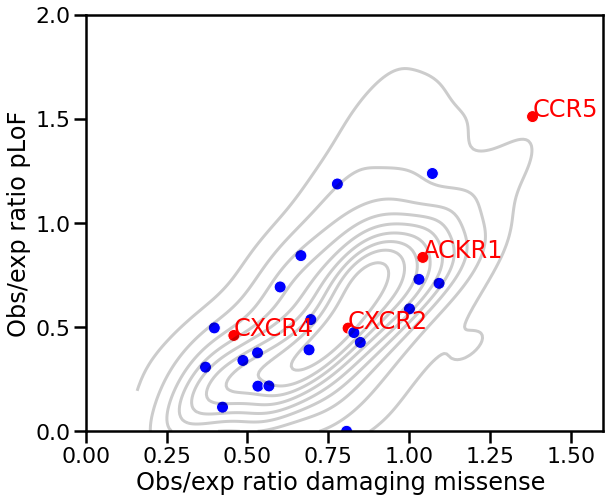

In [102]:


x = chemokines['oe_mis_pphen']
y = chemokines['oe_lof']

fig, ax = plt.subplots(figsize=(9,7.5))
sns.set_context('poster')
sns.kdeplot(data=gpcr_constraint,x='oe_mis_pphen',y='oe_lof',color='k',alpha=0.2,ax=ax,cut=0)
sns.scatterplot(x=x,y=y,hue = chemokines['HGNC symbol'].isin(['CCR5','ACKR1','CXCR2','CXCR4']),palette=('blue','red'))
#ax.errorbar(x, y, yerr=yerr, fmt='.',ecolor=col,alpha=0.5)
annotate_point = lambda gene, kw: \
    ax.annotate(gene,
        (x[chemokines['HGNC symbol']==gene],
         y[chemokines['HGNC symbol']==gene]),
        **kw
    )

annotate_point('CCR5',{'c':'r'})
annotate_point('ACKR1',{'c':'r'})
annotate_point('CXCR2',{'c':'r'})
annotate_point('CXCR4',{'c':'r'})
ax.set_xlim((0.,1.6))
ax.set_ylim((0,2))
ax.set_yticks((0,0.5,1,1.5,2))
# for i, txt in enumerate(chemokines['HGNC symbol']):
#     ax.annotate(txt, (x.values[i], y.values[i]))
ax.set_xlabel('Obs/exp ratio damaging missense ')
ax.set_ylabel('Obs/exp ratio pLoF')
ax.get_legend().remove()
# legend_colors = [matplotlib.patches.Circle((0,0),color=c) for c in custom_cols]
# plt.legend(legend_colors, ['AC','CC','CXC','XC'],
#            title='Motif',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig('../plots/overall_constraint/chemokine_constraint_scatterplot.png',dpi=250)

In [175]:
# View of the raw mutations
def missense_log_plot(Uniprot_name_list):
        #gene_residue_labels = residue_labels_classA[residue_labels_classA['Uniprot_name'] == Uniprot_name]   
    fig, axs = plt.subplots(nrows=len(Uniprot_name_list))
    for i, protein in enumerate(Uniprot_name_list):
        gene_missense_variants = missense_variants_classA[
            missense_variants_classA['Uniprot_name'] == protein
        ]
        #print(gene_missense_variants)
        sns.barplot(
            data=gene_missense_variants,
            x='sequence_position',
            y='allele_count',
            ax=axs[i]
        )
        axs[i].semilogy()
    return None


In [ ]:
missense_variants_classA['consequence'].value_counts()
# g = sns.countplot(data=missense_variants_classA, x='consequence')
# g.set_xticklabels(g.xaxis.get_majorticklabels(),rotation=30)
# g.set_xlabel('VEP categorical label')
missense_variants_classA[['SIFT_cat','SIFT_number']] = missense_variants_classA['SIFT'].str.split('(',expand=True)
g = sns.countplot(data=missense_variants_classA, x='SIFT_cat')
g.set_xticklabels(g.xaxis.get_majorticklabels(),rotation=30)
g.set_xlabel('SIFT categorical label')
missense_variants_classA[['PolyPhen_cat','PolyPhen_number']] = missense_variants_classA['PolyPhen'].str.split('(',expand=True)
g = sns.countplot(data=missense_variants_classA, x='PolyPhen_cat')
g.set_xticklabels(g.xaxis.get_majorticklabels(),rotation=30)
g.set_xlabel('Polyphen categorical label')

In [84]:
chemokines.sort_values('oe_lof_upper')['HGNC symbol']

93      CXCR5
2       ACKR3
64       CCR1
71       CCR7
91      CXCR3
68       CCR4
66       CCR2
88     CX3CR1
70       CCR6
92      CXCR4
391      XCR1
73       CCR9
90      CXCR2
72       CCR8
65      CCR10
67       CCR3
1       ACKR2
94      CXCR6
0       ACKR1
74      CCRL2
3       ACKR4
89      CXCR1
69       CCR5
Name: HGNC symbol, dtype: object

In [164]:
oe_position_chemokines = oe_position[oe_position['HGNC symbol'].isin(chemokines['HGNC symbol'])]
oe_position_chemokines.to_csv('../data/gnomAD_population_variants/gnomad_v2.1.1_chemokine_position_constraint.csv')

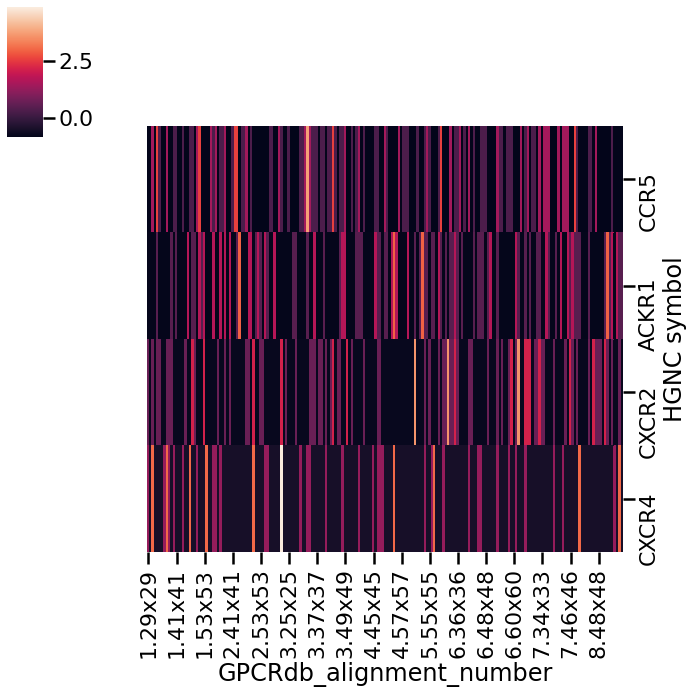

In [180]:
#fig,ax = plt.subplots(figsize=(11,8))
chemokines_wide = oe_position_chemokines.pivot(index='HGNC symbol',columns='GPCRdb_alignment_number',values='oe_missense_position').dropna(axis=1)
chemokines_selected = chemokines_wide.loc[['CCR5','ACKR1','CXCR2','CXCR4'],:]
sns.clustermap(data=chemokines_selected,col_cluster=False,row_cluster=False,metric='cosine',z_score='null')

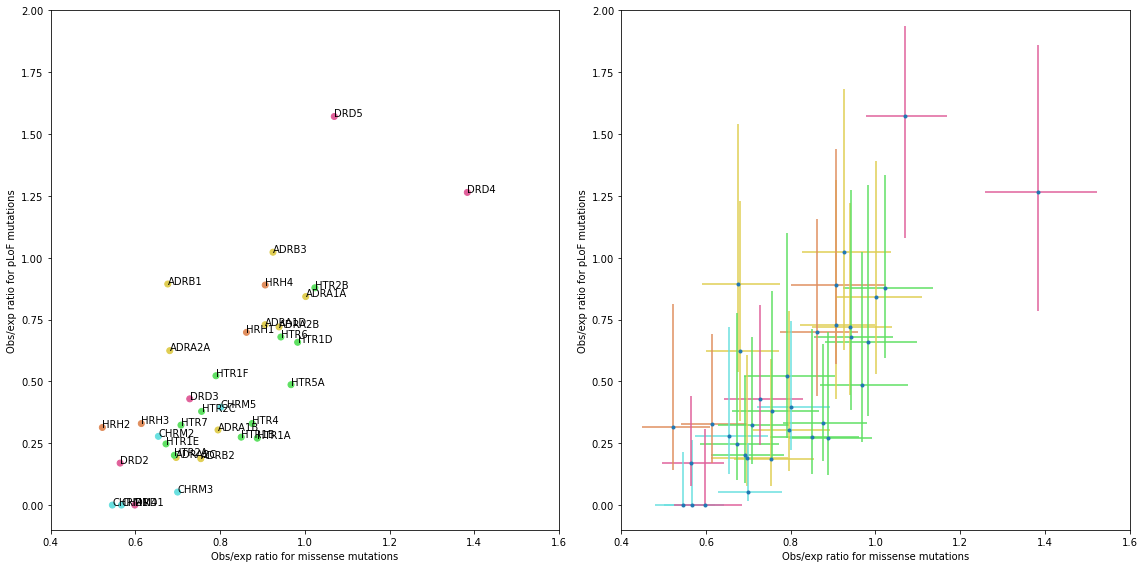

In [6]:
aminergics = gpcr_constraint_by_class[
    (gpcr_constraint_by_class['Ligand_type'] == 'Aminergic') & \
    (gpcr_constraint_by_class['Family'] != 'Trace amine')
]

x = aminergics['oe_mis']
y = aminergics['oe_lof']
xerr = np.stack((aminergics['oe_mis'] - aminergics['oe_mis_lower'], aminergics['oe_mis_upper'] - aminergics['oe_mis']))
yerr = np.stack((aminergics['oe_lof'] - aminergics['oe_lof_lower'], aminergics['oe_lof_upper'] - aminergics['oe_lof']))
col = aminergics.Family.map(dict(zip(
    ['5-Hydroxytryptamine', 'Acetylcholine (muscarinic)','Adrenoceptors', 'Dopamine', 'Histamine'],
    ['#5EE062','#69E0E0','#E0CE53','#E0609A','#E08E5E']
)))
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
ax1.scatter(x,y,c=col)
for i, txt in enumerate(aminergics['HGNC symbol']):
    ax1.annotate(txt, (x.values[i], y.values[i],))
ax1.set_xlabel('Obs/exp ratio for missense mutations')
ax1.set_ylabel('Obs/exp ratio for pLoF mutations')
ax1.set_xlim((0.4,1.6))
ax1.set_ylim((-0.1,2))

ax2.errorbar(x, y, xerr=xerr, yerr=yerr,ecolor=col, fmt='.')
ax2.set_xlabel('Obs/exp ratio for missense mutations')
ax2.set_ylabel('Obs/exp ratio for pLoF mutations')
ax2.set_xlim((0.4,1.6))
ax2.set_ylim((-0.1,2))
#plt.legend(title='Family',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig('../plots/aminergic_constraint_scatterplot.png',dpi=250)

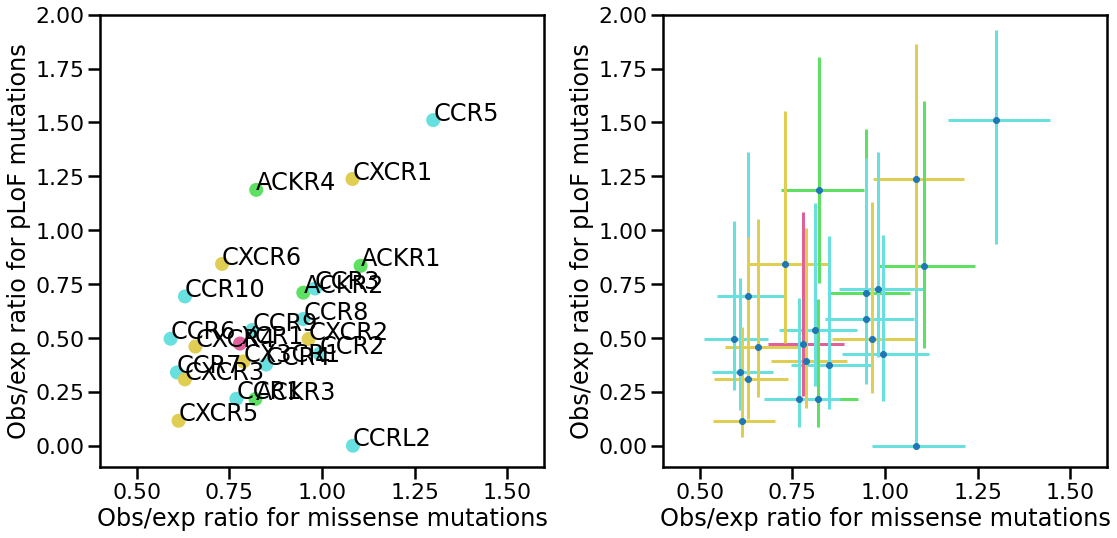

In [7]:
sns.set_context('poster')
chemokines = gpcr_constraint_by_class[
    (gpcr_constraint_by_class['Family'] == 'Chemokine')
]
x = chemokines['oe_mis']
y = chemokines['oe_lof']
xerr = np.stack((chemokines['oe_mis'] - chemokines['oe_mis_lower'], chemokines['oe_mis_upper'] - chemokines['oe_mis']))
yerr = np.stack((chemokines['oe_lof'] - chemokines['oe_lof_lower'], chemokines['oe_lof_upper'] - chemokines['oe_lof']))
col = chemokines['HGNC symbol'].str.slice(stop=2).map(dict(zip(
    ['AC','CC','CX','XC'],
    ['#5EE062','#69E0E0','#E0CE53','#E0609A']
)))


fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
ax1.scatter(x,y,c=col)
for i, txt in enumerate(chemokines['HGNC symbol']):
    ax1.annotate(txt, (x.values[i], y.values[i]))
ax1.set_xlabel('Obs/exp ratio for missense mutations')
ax1.set_ylabel('Obs/exp ratio for pLoF mutations')
ax1.set_xlim((0.4,1.6))
ax1.set_ylim((-0.1,2))

ax2.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.',ecolor=col)
ax2.set_xlabel('Obs/exp ratio for missense mutations')
ax2.set_ylabel('Obs/exp ratio for pLoF mutations')
ax2.set_xlim((0.4,1.6))
ax2.set_ylim((-0.1,2))
#plt.legend(title='Family',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig('../plots/chemokine_constraint_scatterplot.png',dpi=250)

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
adhesions = gpcr_constraint_by_class[gpcr_constraint_by_class['Ligand type'] == 'Adhesion']
ax.errorbar(adhesions['oe_mis_upper'], adhesions['oe_lof_upper'],fmt='.k')
plt.xlabel('Obs/exp ratio for missense mutations (lower bound)')
plt.ylabel('Obs/exp ratio for pLoF mutations (lower bound)')
for i, txt in enumerate(adhesions['HGNC symbol']):
    ax.annotate(txt, (adhesions['oe_mis_upper'].values[i], adhesions['oe_lof_upper'].values[i]))
#plt.savefig('../plots/adhesion_constraint_scatterplot.png')

In [ ]:
# Haploinsufficient GPCRs
fig, (ax1, ax2) = plt.subplots(figsize=(8,8))
haploinsufficients = gpcr_constraint_by_class[gpcr_constraint_by_class['oe_lof_upper'] < 0.5]
lof_errors = np.stack((
    haploinsufficients['oe_lof'] - haploinsufficients['oe_lof_lower'],
    haploinsufficients['oe_lof_upper'] - haploinsufficients['oe_lof']
))
mis_errors = np.stack((
    haploinsufficients['oe_mis'] - haploinsufficients['oe_mis_lower'],
    haploinsufficients['oe_mis_upper'] - haploinsufficients['oe_mis']
))
ax1.errorbar(haploinsufficients['oe_mis_upper'], haploinsufficients['oe_lof_upper'],xerr=mis_errors,yerr=lof_errors,fmt='.k')
plt.xlabel('Obs/exp ratio for missense mutations (upper bound)')
plt.ylabel('Obs/exp ratio for pLoF mutations (upper bound)')
# for i, txt in enumerate(haploinsufficients['HGNC symbol']):
#     ax.annotate(txt, (haploinsufficients['oe_mis_upper'].values[i], haploinsufficients['oe_lof_upper'].values[i]))

sns.scatterplot(data=haploinsufficients,x='oe_mis_upper',y='oe_lof_upper',hue='Class',ax=ax2)